loading annotations into memory...
Done (t=0.18s)
creating index...
index created!
There are 51848 images in the training set
There are 17091 annotations in the training set
{'height': 640, 'width': 1024, 'daytime': 'night', 'file_name': '58c58331bc2601370015aa43.png', 'id': 7027652, 'recordings_id': 36.0, 'timestamp': 6307696984}
File path: ../../../data/validation/nightowls_validation/58c58331bc2601370015aa43.png
Number of annotations in the image: 3
{'occluded': False, 'difficult': False, 'bbox': [179, 233, 41, 119], 'id': 7014321, 'category_id': 1, 'image_id': 7027652, 'pose_id': 4, 'tracking_id': 7001032, 'ignore': 0, 'area': 4879, 'truncated': False}
{'occluded': False, 'difficult': False, 'bbox': [60, 223, 27, 90], 'id': 7014322, 'category_id': 1, 'image_id': 7027652, 'pose_id': 2, 'tracking_id': 7001033, 'ignore': 0, 'area': 2430, 'truncated': False}
{'occluded': False, 'difficult': False, 'bbox': [104, 228, 31, 97], 'id': 7014323, 'category_id': 1, 'image_id': 7027652, 'pose_i

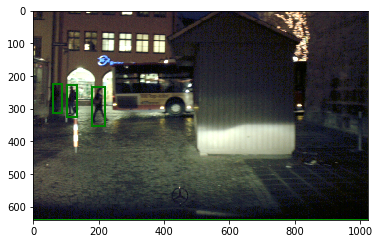

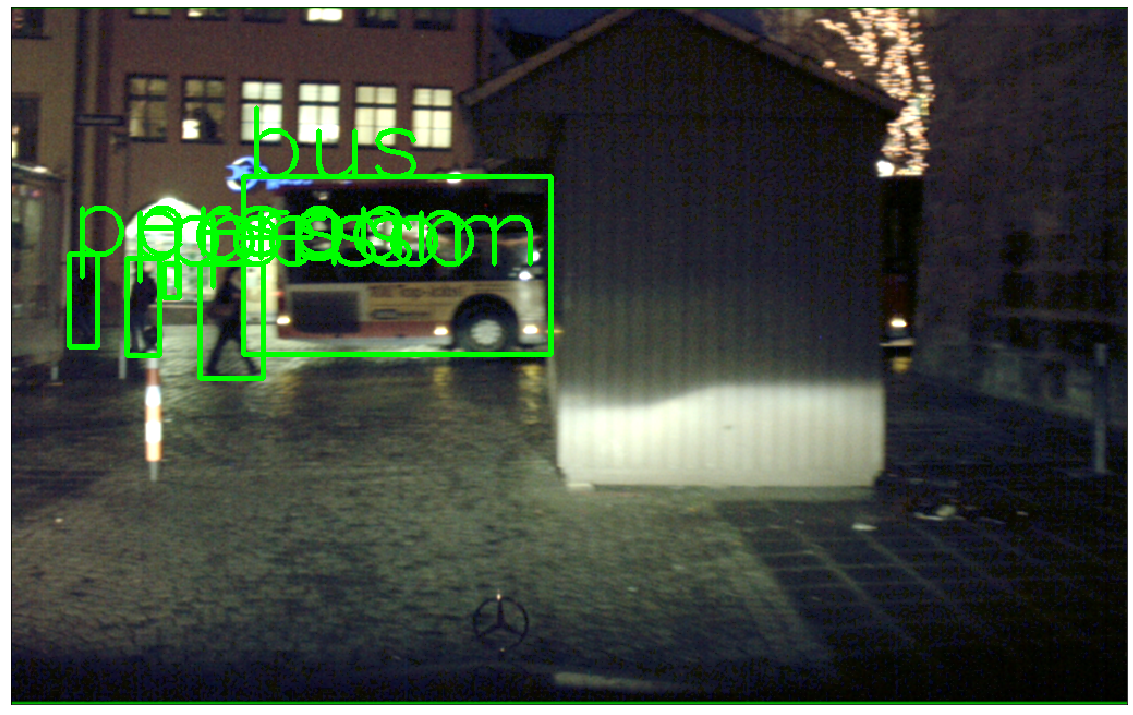

In [12]:
import random
from os import path
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches

from coco import COCO

# import necessary libraries
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as T
import torchvision
import torch
import numpy as np
import cv2

# get the pretrained model from torchvision.models
# Note: pretrained=True will get the pretrained weights for the model.
# model.eval() to use the model for inference
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model.eval()

# Class labels from official PyTorch documentation for the pretrained model
# Note that there are some N/A's 
# for complete list check https://tech.amikelive.com/node-718/what-object-categories-labels-are-in-coco-dataset/
# we will use the same list for this notebook
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]


def get_prediction(img_path, threshold):
  """
  get_prediction
    parameters:
      - img_path - path of the input image
      - threshold - threshold value for prediction score
    method:
      - Image is obtained from the image path
      - the image is converted to image tensor using PyTorch's Transforms
      - image is passed through the model to get the predictions
      - class, box coordinates are obtained, but only prediction score > threshold
        are chosen.
    
  """
  img = Image.open(img_path)
  transform = T.Compose([T.ToTensor()])
  img = transform(img)
  pred = model([img])
  pred_class = [COCO_INSTANCE_CATEGORY_NAMES[i] for i in list(pred[0]['labels'].numpy())]
  pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().numpy())]
  pred_score = list(pred[0]['scores'].detach().numpy())
  pred_t = [pred_score.index(x) for x in pred_score if x>threshold][-1]
  pred_boxes = pred_boxes[:pred_t+1]
  pred_class = pred_class[:pred_t+1]
  return pred_boxes, pred_class
  


def object_detection_api(img_path, threshold=0.5, rect_th=3, text_size=3, text_th=3):
  """
  object_detection_api
    parameters:
      - img_path - path of the input image
      - threshold - threshold value for prediction score
      - rect_th - thickness of bounding box
      - text_size - size of the class label text
      - text_th - thichness of the text
    method:
      - prediction is obtained from get_prediction method
      - for each prediction, bounding box is drawn and text is written 
        with opencv
      - the final image is displayed
  """
  boxes, pred_cls = get_prediction(img_path, threshold)
  img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  for i in range(len(boxes)):
    cv2.rectangle(img, boxes[i][0], boxes[i][1],color=(0, 255, 0), thickness=rect_th)
    cv2.putText(img,pred_cls[i], boxes[i][0], cv2.FONT_HERSHEY_SIMPLEX, text_size, (0,255,0),thickness=text_th)
  plt.figure(figsize=(20,30))
  plt.imshow(img)
  plt.xticks([])
  plt.yticks([])
  plt.show()

# path to the ground truth annotation and the data
annFile = '../../../data/nightowls_validation.json'
image_directory = '../../../data/validation/nightowls_validation'

# load the annotations and the list of images
cocoGt = COCO(annFile)
imgIds = sorted(cocoGt.getImgIds())
print('There are %d images in the training set' % len(imgIds))
annotations = cocoGt.getAnnIds()
print('There are %d annotations in the training set' % len(annotations))

for i in range(1):
    
    # get a random image and its path
    # im_id = imgIds[random.randint(0, len(imgIds))] 
    im_id = 7027652
    image = cocoGt.loadImgs(ids=im_id)[0]
    file_path = path.join(image_directory, image['file_name'])
    

    # get the annotations of the images
    anns = cocoGt.getAnnIds([image['id']])
    
    
    if(len(anns) < 1):
        continue

    print(image)
    print('File path: ' + str(file_path))
    print('Number of annotations in the image: ' + str(len(anns)))
    
    # draw the annotations on the image
    img=mpimg.imread(file_path)
    fig,ax = plt.subplots(1)
    ax.imshow(img)

    for ann_id in anns:
        ann = cocoGt.loadAnns(ids=ann_id)[0]
        print(ann)
        bbox = ann['bbox']
        rect = patches.Rectangle((bbox[0],bbox[1]),bbox[2],bbox[3],linewidth=2,edgecolor='g',facecolor='none')
        ax.add_patch(rect)

    #print
    plt.show()
    
    object_detection_api(file_path, threshold=0.8)
